## Vertical Cross-Sections of the Atmosphere
#### ATM S 370 - Winter 2022 - Lab 15
Author: Ajda Savarin

Contributor: Kamran Kazemi
***

In [1]:
from datetime import datetime, timedelta
from metpy.units import units
from netCDF4 import Dataset
from scipy.interpolate import interp1d, interp2d

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import os

In [2]:
### Functions from Python IV
print('Defining functions from Python IV lab.')
def calculate_crossSectionField(lons=np.arange(10), lats=np.arange(10), levels=np.arange(10), 
                           field=np.zeros((10, 10, 10)), 
                           startLon=0, startLat=0, endLon=1, endLat=1, 
                           nPts=101, nLevs=101):
    """
    Calculates data along a vertical cross-section given:
     - longitudes of all data (degrees EAST), must be 1D, with units
     - latitides of all data (degrees NORTH), must be 1D, with units
     - levels of all data, with units (in mb or hPa)
     - an input field to convert (default = potential temperature (K))
     - starting and ending longitude (degrees EAST)
     - starting and ending latitude (degrees NORTH)
     - number of points along a cross-section (nPts) and number of desired vertical levels (nLevs)
    
    
    Outputs:
     - out_var - field along vertical cross-section (level, point)
     - lon_vals - longitudes along vertical cross-section (point, in degrees EAST)
     - lat_vals - latitudes along vertical cross-section (point, in degrees NORTH)
     - lev_vals - vertical levels (level, in mb or hPa)
    """
    lon_vals = np.linspace(startLon, endLon, nPts)
    lat_vals = np.linspace(startLat, endLat, nPts)
    lev_vals = np.linspace(100, levels[-1].magnitude, nLevs)
    
    out_var = np.zeros((nLevs, nPts)) * np.nan
    tmp_var = np.zeros((len(field), nPts)) * np.nan
        
    for lev in range(len(field)):
        intpTmp = interp2d(lons, lats, field[lev])
        for pt in range(nPts):
            tmp_var[lev, pt] = intpTmp(lon_vals[pt], lat_vals[pt])
        
    for pt in range(nPts):
        intpTmp = interp1d(levels, tmp_var[:, pt])
        out_var[:, pt] = intpTmp(lev_vals)
    
    out_var = out_var * field.units
    lon_vals = lon_vals * lons.units
    lat_vals = lat_vals * lats.units
    lev_vals = lev_vals * levels.units
    
    return out_var, lon_vals, lat_vals, lev_vals

def calc_winds_normalToCrossSection(u=np.zeros((10, 10)), v=np.zeros((10, 10)), 
                                           lons=np.arange(10), lats=np.arange(10)):
    """
    Calculates winds NORMAL to a vertical cross-section given:
     - u and v component of winds ALONG a given cross-section (use calculate_crossSection())
     - longitudes and latitudes of the cross-section (returned by calculate_crossSection())    
    
    Outputs:
     - u_perp - zonal wind component normal to the cross-section
     - v_perp - meridional wind component normal to the cross-section
     - line_angle - the tilt of the cross-section compared to the horizontal (in degrees)
    """
    
    dx = lons[-1] - lons[0]
    dy = lats[-1] - lats[0]
    
    line_angle = np.arctan2(dy,dx)
    
    u_normal = -u * np.sin(line_angle)
    v_normal = v * np.cos(line_angle)
    wspd_normal = u_normal + v_normal
    return u_normal, v_normal, wspd_normal, line_angle*180/np.pi*units('degree/radian')

Defining functions from Python IV lab.


In [3]:
fIn_pressure = 'ATMS370_W2022_Lab15_VerticalCrossSections_dataPressure.nc'
fIn_surface = 'ATMS370_W2022_Lab15_VerticalCrossSections_dataSurface.nc'

fIn_pressure_exists = os.path.isfile(fIn_pressure)
fIn_surface_exists = os.path.isfile(fIn_surface)

print('Do the files I am referencing exist?')
print('Pressure:', fIn_pressure_exists)
print('Surface:', fIn_surface_exists)

if fIn_pressure_exists and fIn_surface_exists:
    print('Yes, I am good to go on!')
elif fIn_pressure_exists and not fIn_surface_exists:
    print('Oh no! I am missing the surface data file!')
elif not fIn_pressure_exists and fIn_surface_exists:
    print('Oh no! I am missing the pressure data file!')
else:
    print('Oh no! I am missing both data files!')

Do the files I am referencing exist?
Pressure: True
Surface: True
Yes, I am good to go on!


## 1. Maps

Use previous labs as guides if you forgot how to do stuff!

In [4]:
### 1.1a
print('1.1a)')

dataPressure = Dataset(fIn_pressure, 'r')
dataPressure.variables

1.1a)


{'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (181,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'level': <class 'netCDF4._netCDF4.Variable'>
 int32 level(level)
     units: millibars
     long_name: pressure_level
 unlimited dimensions: 
 current shape = (11,)
 filling on, default _FillValue of -2147483647 used,
 'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (401,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 't': <class 'netCDF4._netCDF4.Variable'>
 int16 t(time, level, latitude, longitude)
     scale_factor: 0.002043232954094335
     add_offset: 250.15325237033935
     _FillValue: -32767
     missing_value: -32767
     units: K
     long_name: Temperature
     standard_name: air_temperature
 unlimited

In [5]:
### 1.1b
print('1.1b)')

dataset_startTime = datetime.strptime('1900-01-01', '%Y-%m-%d')
time = np.array(dataPressure['time'])
dataset_time = [dataset_startTime + timedelta(hours = int(time[i])) for i in range(0, len(time), 1)]
dataset_time = [times.strftime('%B %d, %Y %HUTC') for times in dataset_time]
level = np.array(dataPressure['level'])
level = level * units('mbar')
longitude = np.array(dataPressure['longitude'])
latitude = np.array(dataPressure['latitude'])
longitude = longitude * units('degree')
latitude = latitude * units('degree')

1.1b)


In [6]:
### 1.1c
print('1.1c)')

u_wind = np.array(dataPressure['u'])
v_wind = np.array(dataPressure['v'])
z = np.array(dataPressure['z'])
t = np.array(dataPressure['t'])

u_wind = u_wind * units('m s**-1')
v_wind = v_wind * units('m s**-1')
z = z * units('m**2 s**-2')
t = t * units('degK')

g = 9.81 * units('m s**-2')
geo_height = z / g

print(geo_height.units)

dataPressure.close()

1.1c)
meter


In [7]:
### 1.1d
print('1.1d)')

wspd = np.sqrt((u_wind)**2 + (v_wind)**2)
wspd = wspd.to('kt')

1.1d)


In [8]:
### 1.1e
print('1.1e)')

levelGrid = np.swapaxes(np.tile(level, [len(longitude), len(latitude), 1]), 0, 2)
theta = mpcalc.potential_temperature(levelGrid, t)
print(theta.shape)

1.1e)
(4, 11, 181, 401)


In [9]:
### 1.2a
print('1.2a)')

dataSurface = Dataset(fIn_surface, 'r')
dataSurface.variables

1.2a)


{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (401,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (181,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (4,)
 filling on, default _FillValue of -2147483647 used,
 't2m': <class 'netCDF4._netCDF4.Variable'>
 float64 t2m(time, latitude, longitude)
     _FillValue: -32767.0
     missing_value: -32767
     units: K
     long_name: 2 metre temperature
 unlimited dimensions: 
 current shape = (4, 181, 401)
 filling on,
 'msl': <c

In [10]:
### 1.2b
print('1.2b)')

msl = np.array(dataSurface['msl'])
msl = msl * units('Pa')
msl = msl.to('hPa')

t2m = np.array(dataSurface['t2m'])
t2m = t2m * units('degK')
t2m = t2m.to('degC')

dataSurface.close()

1.2b)


EX1
Refresher on maps.


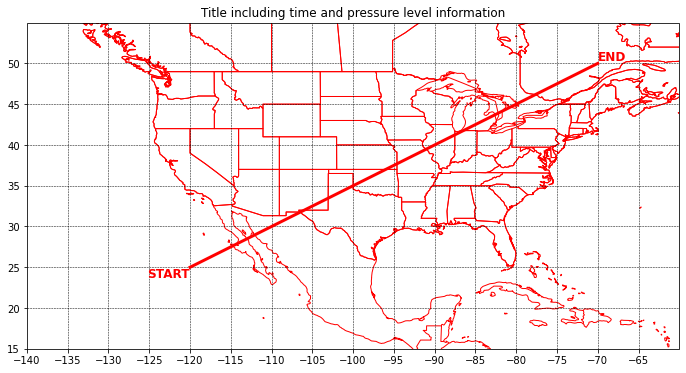

In [11]:
### EX1
lonMin, lonMax, latMin, latMax = 220, 300, 15, 55 
lonMin_units, lonMax_units = lonMin*units('degree'), lonMax*units('degree')
latMin_units, latMax_units = latMin*units('degree'), latMax*units('degree')

print('EX1')
print('Refresher on maps.')


fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cf.COASTLINE, edgecolor='r')
ax.add_feature(cf.BORDERS, edgecolor='r')
ax.add_feature(cf.STATES, edgecolor='r')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='k', linestyle='--', xlocs=np.arange(lonMin, lonMax+1, 5)%-180, ylocs=np.arange(latMin, latMax, 5))

ax.set_xticks(np.arange(lonMin%-180, lonMax%-180, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(latMin, latMax, 5), crs=ccrs.PlateCarree())

ax.set_extent([lonMin%-180, lonMax%-180, latMin, latMax], crs=ccrs.PlateCarree())

# adding lines and text to maps
sLon, sLat, eLon, eLat = 240, 25, 290, 50
ax.plot([sLon, eLon], [sLat, eLat], c='r', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon, sLat, 'START', ha='right', va='top', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)
ax.text(eLon, eLat, 'END', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)

#format contour label to not have decimal places
#ax.clabel(f1, fmt='%1.0f')

# plt.colorbar(f1, label='Wind speed (kt)')

ax.set_title('Title including time and pressure level information')
#plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_name.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)


plt.show()

In [12]:
### 1.3a
print('1.3a)')

print(level)

pressure_index = 3

print(level[pressure_index])

1.3a)
[  50  100  200  300  400  500  600  700  800  900 1000] millibar
300 millibar


In [13]:
### 1.3b
print('1.3b)')

desired_time = datetime.strptime('2003-02-03 12UTC', '%Y-%m-%d %HUTC')
desired_time = desired_time.strftime('%B %d, %Y %HUTC')
timeInd = dataset_time.index(desired_time)
time_1 = dataset_time[timeInd]
print(time_1)

1.3b)
February 03, 2003 12UTC


1.3c)
(161, 321)
(161, 321)
(4, 161, 321)
(4, 161, 321)


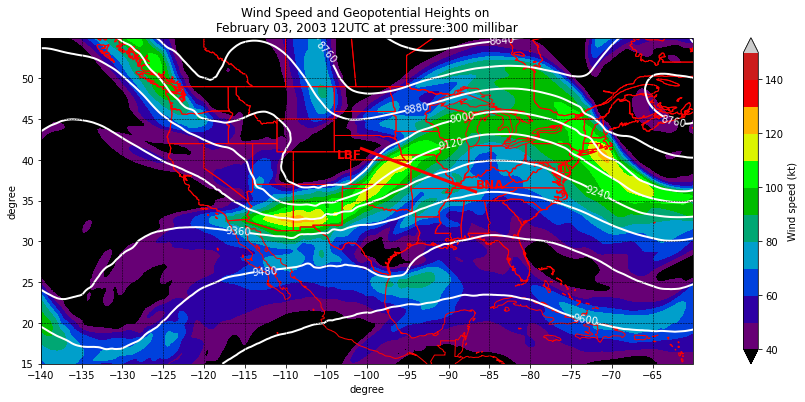

In [14]:
### 1.3c
print('1.3c)')

lonMin, lonMax, latMin, latMax = 220, 300, 15, 55 
lonMin_units, lonMax_units = lonMin*units('degree'), lonMax*units('degree')
latMin_units, latMax_units = latMin*units('degree'), latMax*units('degree')

lonMinInd = np.argmin(np.abs(longitude-lonMin_units))
lonMaxInd = np.argmin(np.abs(longitude-lonMax_units))
latMinInd = np.argmin(np.abs(latitude-latMin_units))
latMaxInd = np.argmin(np.abs(latitude-latMax_units))

lon_subset = (longitude[lonMinInd:lonMaxInd + 1] % 180)
lat_subset = latitude[latMinInd:latMaxInd + 1]

u_300 = u_wind[:, pressure_index, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]
v_300 = v_wind[:, pressure_index, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]
z_300 = z[:, pressure_index, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]
geo_height_300 = z_300 / g

wspd_300 = wspd[:, pressure_index, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]

lonGrid, latGrid = np.meshgrid(lon_subset, lat_subset)

print(lonGrid.shape)
print(latGrid.shape)
print(z_300.shape)
print(geo_height_300.shape)


fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cf.COASTLINE, edgecolor='r')
ax.add_feature(cf.BORDERS, edgecolor='r')
ax.add_feature(cf.STATES, edgecolor='r')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='k', linestyle='--', xlocs=np.arange(lonMin, lonMax+1, 5)%-180, ylocs=np.arange(latMin, latMax, 5))
cs = ax.contour(lonGrid, latGrid, geo_height_300[timeInd, :, :], levels=np.arange(8640, 10001, 120), colors='w', linewidths=2, transform=ccrs.PlateCarree())
f1 = ax.contourf(lonGrid, latGrid, wspd_300[timeInd, :, :], levels=np.arange(40, 151, 10), cmap='nipy_spectral', extend='both', transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(lonMin%-180, lonMax%-180, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(latMin, latMax, 5), crs=ccrs.PlateCarree())

ax.set_extent([lonMin%-180, lonMax%-180, latMin, latMax], crs=ccrs.PlateCarree())

# adding lines and text to maps
sLon, sLat, eLon, eLat = 259.3, 41.4, 273.3, 36.1
ax.plot([sLon, eLon], [sLat, eLat], c='r', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon, sLat, 'LBF', ha='right', va='top', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)
ax.text(eLon, eLat, 'BNA', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)

#format contour label to not have decimal places
ax.clabel(cs, fmt='%1.0f')

plt.colorbar(f1, label='Wind speed (kt)')

ax.set_title('Wind Speed and Geopotential Heights on \n' + dataset_time[timeInd] + ' at pressure:' + str(level[pressure_index]))
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_1.3.1.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()

1.3d)


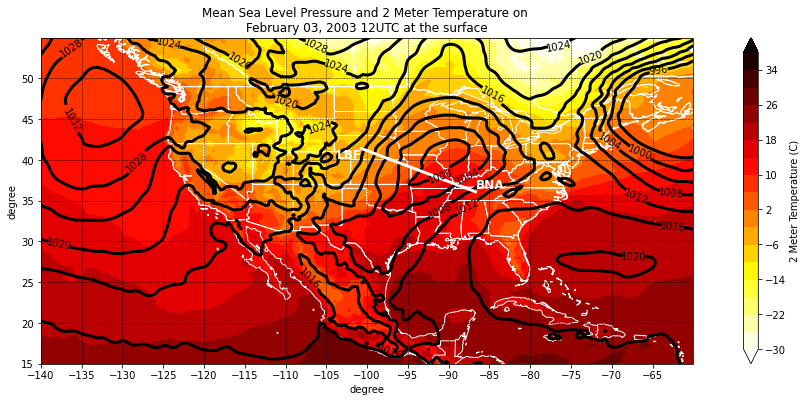

In [15]:
### 1.3d
print('1.3d)')

msl_1 = msl[:, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]
t2m_1 = t2m[:, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]

fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cf.COASTLINE, edgecolor='w')
ax.add_feature(cf.BORDERS, edgecolor='w')
ax.add_feature(cf.STATES, edgecolor='w')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='k', linestyle='--', xlocs=np.arange(lonMin, lonMax+1, 5)%-180, ylocs=np.arange(latMin, latMax, 5))
cs = ax.contour(lonGrid, latGrid, msl_1[timeInd,: , :], levels=np.arange(996, 1041, 4), colors='k', linewidths=3, transform=ccrs.PlateCarree())
f1 = ax.contourf(lonGrid, latGrid, t2m_1[timeInd,: , :], levels=np.arange(-30, 40, 4), cmap='hot_r', extend='both', transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(lonMin%-180, lonMax%-180, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(latMin, latMax, 5), crs=ccrs.PlateCarree())

ax.set_extent([lonMin%-180, lonMax%-180, latMin, latMax], crs=ccrs.PlateCarree())

# adding lines and text to maps
sLon, sLat, eLon, eLat = 259.3, 41.4, 273.3, 36.1
ax.plot([sLon, eLon], [sLat, eLat], c='w', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon, sLat, 'LBF', ha='right', va='top', transform=ccrs.PlateCarree(), color='w', fontweight='semibold', fontsize=12)
ax.text(eLon, eLat, 'BNA', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='w', fontweight='semibold', fontsize=12)

#format contour label to not have decimal places
ax.clabel(cs, fmt='%1.0f')

plt.colorbar(f1, label='2 Meter Temperature (C)')

ax.set_title('Mean Sea Level Pressure and 2 Meter Temperature on \n' + dataset_time[timeInd] + ' at the surface')
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_1.3.2.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()

1.4a)


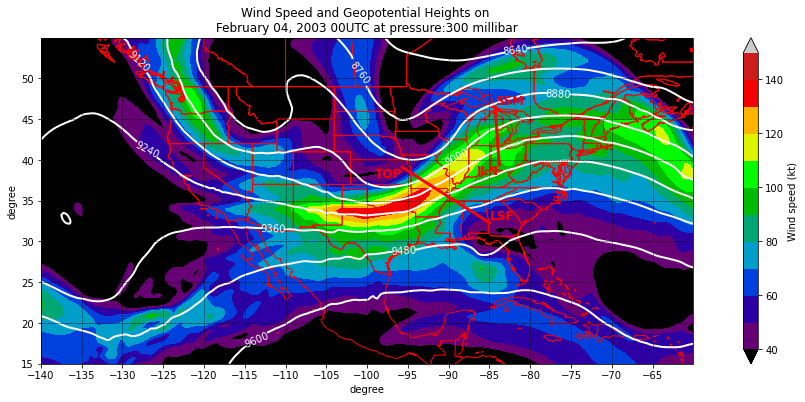

In [16]:
### 1.4a
print('1.4a)')

desired_time = datetime.strptime('2003-02-04 00UTC', '%Y-%m-%d %HUTC')
desired_time = desired_time.strftime('%B %d, %Y %HUTC')
timeInd = dataset_time.index(desired_time)

fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cf.COASTLINE, edgecolor='r')
ax.add_feature(cf.BORDERS, edgecolor='r')
ax.add_feature(cf.STATES, edgecolor='r')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='k', linestyle='--', xlocs=np.arange(lonMin, lonMax+1, 5)%-180, ylocs=np.arange(latMin, latMax, 5))
cs = ax.contour(lonGrid, latGrid, geo_height_300[timeInd, :, :], levels=np.arange(8640, 10001, 120), colors='w', linewidths=2, transform=ccrs.PlateCarree())
f1 = ax.contourf(lonGrid, latGrid, wspd_300[timeInd, :, :], levels=np.arange(40, 151, 10), cmap='nipy_spectral', extend='both', transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(lonMin%-180, lonMax%-180, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(latMin, latMax, 5), crs=ccrs.PlateCarree())

ax.set_extent([lonMin%-180, lonMax%-180, latMin, latMax], crs=ccrs.PlateCarree())

# adding lines and text to maps
sLon1, sLat1, eLon1, eLat1 = 264.3, 39.1, 275, 32.3
ax.plot([sLon1, eLon1], [sLat1, eLat1], c='r', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon1, sLat1, 'TOP', ha='right', va='top', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)
ax.text(eLon1, eLat1, 'LSF', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)

sLon2, sLat2, eLon2, eLat2 = 276.2, 39.4, 275.7, 46.5
ax.plot([sLon2, eLon2], [sLat2, eLat2], c='r', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon2, sLat2, 'ILN', ha='right', va='top', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)
ax.text(eLon2, eLat2, 'SSM', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='r', fontweight='semibold', fontsize=12)

#format contour label to not have decimal places
ax.clabel(cs, fmt='%1.0f')

plt.colorbar(f1, label='Wind speed (kt)')

ax.set_title('Wind Speed and Geopotential Heights on \n' + dataset_time[timeInd] + ' at pressure:' + str(level[pressure_index]))
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_1.4.1.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()

1.4b)


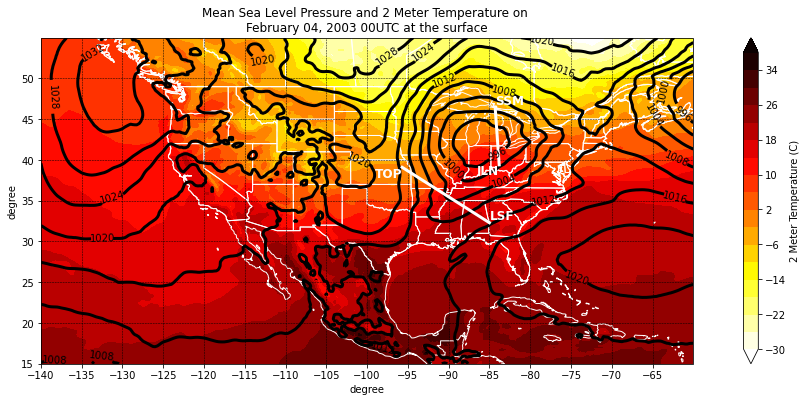

In [17]:
### 1.4b
print('1.4b)')

fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cf.COASTLINE, edgecolor='w')
ax.add_feature(cf.BORDERS, edgecolor='w')
ax.add_feature(cf.STATES, edgecolor='w')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='k', linestyle='--', xlocs=np.arange(lonMin, lonMax+1, 5)%-180, ylocs=np.arange(latMin, latMax, 5))
cs = ax.contour(lonGrid, latGrid, msl_1[timeInd,: , :], levels=np.arange(996, 1041, 4), colors='k', linewidths=3, transform=ccrs.PlateCarree())
f1 = ax.contourf(lonGrid, latGrid, t2m_1[timeInd,: , :], levels=np.arange(-30, 40, 4), cmap='hot_r', extend='both', transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(lonMin%-180, lonMax%-180, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(latMin, latMax, 5), crs=ccrs.PlateCarree())

ax.set_extent([lonMin%-180, lonMax%-180, latMin, latMax], crs=ccrs.PlateCarree())

# adding lines and text to maps
sLon1, sLat1, eLon1, eLat1 = 264.3, 39.1, 275, 32.3
ax.plot([sLon1, eLon1], [sLat1, eLat1], c='w', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon1, sLat1, 'TOP', ha='right', va='top', transform=ccrs.PlateCarree(), color='w', fontweight='semibold', fontsize=12)
ax.text(eLon1, eLat1, 'LSF', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='w', fontweight='semibold', fontsize=12)

sLon2, sLat2, eLon2, eLat2 = 276.2, 39.4, 275.7, 46.5
ax.plot([sLon2, eLon2], [sLat2, eLat2], c='w', lw=3, transform=ccrs.PlateCarree())
ax.text(sLon2, sLat2, 'ILN', ha='right', va='top', transform=ccrs.PlateCarree(), color='w', fontweight='semibold', fontsize=12)
ax.text(eLon2, eLat2, 'SSM', ha='left', va='bottom', transform=ccrs.PlateCarree(), color='w', fontweight='semibold', fontsize=12)

#format contour label to not have decimal places
ax.clabel(cs, fmt='%1.0f')

plt.colorbar(f1, label='2 Meter Temperature (C)')

ax.set_title('Mean Sea Level Pressure and 2 Meter Temperature on \n' + dataset_time[timeInd] + ' at the surface')
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_1.4.2.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()

In [18]:
### 1.4c
print('1.4c)')

1.4c)


## 2. Cross-Section I, TOP – LSF, 00 UTC on 4 Feb 2003

In [19]:
### 2.1a
print('2.1a)')

sLon = 264.3
eLon = 275
sLat = 39.1
eLat = 32.3
"""
startLon_units, endLon_units = startLon*units('degree'), endLon*units('degree')
startLat_units, endLat_units = startLat*units('degree'), endLat*units('degree')

lonMinInd = np.argmin(np.abs(longitude-startLon_units))
lonMaxInd = np.argmin(np.abs(longitude-endLon_units))
latMinInd = np.argmin(np.abs(latitude-startLat_units))
latMaxInd = np.argmin(np.abs(latitude-endLat_units))

lon_subset = (longitude[lonMinInd:lonMaxInd + 1] % 180)
lat_subset = latitude[latMinInd:latMaxInd + 1]

z_cross = z[timeInd, :, latMinInd:(latMaxInd + 1), lonMinInd:(lonMaxInd + 1)]
geo_height_cross = z_300 / g
print(geo_height_cross.shape)
"""

z_cross = z[timeInd, :, :, :]
geo_height_cross = z_cross / g
print(geo_height_cross.units)

2.1a)
meter


In [20]:
### 2.1b
print('2.1b)')

print('First, we need to set empty arrays to fill in with 3d winds:')
ug_3d = np.zeros((len(level), len(latitude), len(longitude)))
vg_3d = np.zeros((len(level), len(latitude), len(longitude)))
print('The shape of 3d wind arrays:', ug_3d.shape)
print('Does the shape of 3d wind arrays match the shape of temperature, pressure grid:', ug_3d.shape == levelGrid.shape)
print('Confirming they are empty arrays:')
print('   -min, max of ug_3d:', np.min(ug_3d), np.max(ug_3d))
print('   -min, max of vg_3d:', np.min(vg_3d), np.max(vg_3d))

print()
print('Calculate everything we need for geostrophic wind function - that does not depend on height.')
lonGrid, latGrid = np.meshgrid(longitude, latitude) # substitute your subset longitude and latitude
f = mpcalc.coriolis_parameter(np.deg2rad(latGrid)).to('1/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lonGrid, latGrid)

print('Now we write a for-loop in which we loop through one level at a time, and calculate geostrophic winds there.')
for lev in range(len(level)):
    ug, vg = mpcalc.geostrophic_wind(geo_height_cross[lev], f, dx, dy)
    
    ug_3d[lev] = ug
    vg_3d[lev] = vg

ug_3d = ug_3d * ug.units
vg_3d = vg_3d * vg.units

ug_3d.to('kt')
vg_3d.to('kt')
ug_3d.shape

2.1b)
First, we need to set empty arrays to fill in with 3d winds:
The shape of 3d wind arrays: (11, 181, 401)
Does the shape of 3d wind arrays match the shape of temperature, pressure grid: True
Confirming they are empty arrays:
   -min, max of ug_3d: 0.0 0.0
   -min, max of vg_3d: 0.0 0.0

Calculate everything we need for geostrophic wind function - that does not depend on height.
Now we write a for-loop in which we loop through one level at a time, and calculate geostrophic winds there.


(11, 181, 401)

In [21]:
### 2.2a
print('2.2a)')
u_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=ug_3d, startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)
v_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=vg_3d, startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)
theta_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=theta[timeInd, :, :, :], startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)

2.2a)


In [22]:
### 2.2b
print('2.2b)')

u_normal, v_normal, wspd_normal, angle = calc_winds_normalToCrossSection(u=u_alongCrossSection, v=v_alongCrossSection, lons=lonX, lats=latX)

2.2b)


2.3a)


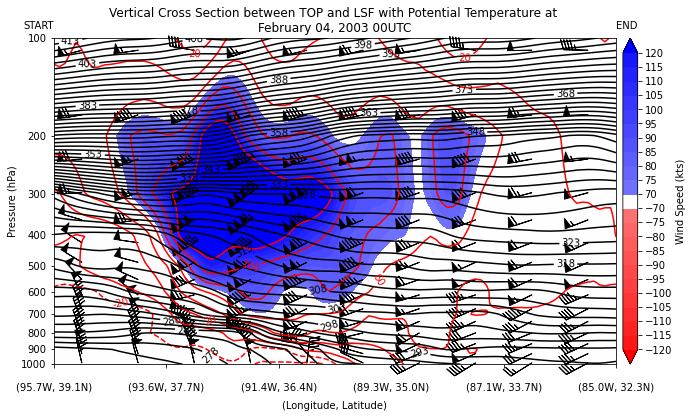

In [23]:
### 2.3a
print('2.3a)')

levels_wsp_normal_shaded = list(np.arange(-120, -69, 5)) + list(np.arange(70, 121, 5))
levels_wsp_normal = np.arange(-120, 121, 20)
levels_theta = np.arange(263, 425, 2.5)
vecSpacing = 7


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

f1 = ax.contourf(range(101), levX, wspd_normal.to('kts'), levels=levels_wsp_normal_shaded, cmap='bwr_r', extend='both', vmin=-130, vmax=130)
cs_wspd = ax.contour(range(101), levX, wspd_normal.to('kts'), levels=levels_wsp_normal, colors='r', linewidths=1.5)
ax.clabel(cs_wspd, cs_wspd.levels[1::2], inline=True, fmt='%1.0f')

th_cont = ax.contour(range(101), levX, theta_alongCrossSection, levels=levels_theta, colors='k', linewidths=1.5)
ax.clabel(th_cont, th_cont.levels[::2], inline=True, fmt='%1.0f')
ax.barbs(range(5, 101, 10), levX[1::vecSpacing], u_alongCrossSection[1::vecSpacing, 5::10].to('kts'), v_alongCrossSection[1::vecSpacing, 5::10].to('kts'), clip_on=False)

cbar = plt.colorbar(f1, ticks=levels_wsp_normal_shaded, label='Wind Speed (kts)', pad=.01)

pairs = ['\n('+'{:.1f}'.format(np.abs(lonX[el].magnitude%-180))+'W, '+'{:.1f}'.format(latX[el].magnitude)+'N)' for el in range(0, 101, 20)]
ax.set_xticks(np.arange(0, 101, 20))

ax.set_xticklabels(pairs)
ax.set_yscale('log')
ax.set_yticks(np.arange(100, 1001, 100))
ax.set_yticklabels(np.arange(100, 1001, 100))
ax.set_xlim(0, 100)
ax.set_ylim(1000, 100)
ax.set_title('Vertical Cross Section between TOP and LSF with Potential Temperature at \n' + dataset_time[timeInd])
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('(Longitude, Latitude)', labelpad=8)
ax.text(0, 95, 'START', ha='right', va='bottom')
ax.text(100, 95, 'END', ha='left', va='bottom')
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_2.3.1.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()

## 3. Cross-Section II, LBF-BNA, 12 UTC on 3 Feb 2003

In [24]:
### 3.1a
print('3.1a)')

sLon, sLat, eLon, eLat = 259.3, 41.4, 273.3, 36.1

desired_time = datetime.strptime('2003-02-03 12UTC', '%Y-%m-%d %HUTC')
desired_time = desired_time.strftime('%B %d, %Y %HUTC')
timeInd = dataset_time.index(desired_time)

z_cross = z[timeInd, :, :, :]
geo_height_cross = z_cross / g

3.1a)


In [25]:
### 3.1b
print('3.1b)')
print('First, we need to set empty arrays to fill in with 3d winds:')
ug_3d = np.zeros((len(level), len(latitude), len(longitude)))
vg_3d = np.zeros((len(level), len(latitude), len(longitude)))
print('The shape of 3d wind arrays:', ug_3d.shape)
print('Does the shape of 3d wind arrays match the shape of temperature, pressure grid:', ug_3d.shape == levelGrid.shape)
print('Confirming they are empty arrays:')
print('   -min, max of ug_3d:', np.min(ug_3d), np.max(ug_3d))
print('   -min, max of vg_3d:', np.min(vg_3d), np.max(vg_3d))

print()
print('Calculate everything we need for geostrophic wind function - that does not depend on height.')
lonGrid, latGrid = np.meshgrid(longitude, latitude) # substitute your subset longitude and latitude
f = mpcalc.coriolis_parameter(np.deg2rad(latGrid)).to('1/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lonGrid, latGrid)

print('Now we write a for-loop in which we loop through one level at a time, and calculate geostrophic winds there.')
for lev in range(len(level)):
    ug, vg = mpcalc.geostrophic_wind(geo_height_cross[lev], f, dx, dy)
    
    ug_3d[lev] = ug
    vg_3d[lev] = vg

ug_3d = ug_3d * ug.units
vg_3d = vg_3d * vg.units

ug_3d.to('kt')
vg_3d.to('kt')
ug_3d.shape

3.1b)
First, we need to set empty arrays to fill in with 3d winds:
The shape of 3d wind arrays: (11, 181, 401)
Does the shape of 3d wind arrays match the shape of temperature, pressure grid: True
Confirming they are empty arrays:
   -min, max of ug_3d: 0.0 0.0
   -min, max of vg_3d: 0.0 0.0

Calculate everything we need for geostrophic wind function - that does not depend on height.
Now we write a for-loop in which we loop through one level at a time, and calculate geostrophic winds there.


(11, 181, 401)

In [26]:
### 3.2a
print('3.2a)')
u_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=ug_3d, startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)
v_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=vg_3d, startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)
theta_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=theta[timeInd, :, :, :], startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)

3.2a)


In [27]:
### 3.2b
print('3.2b)')
u_normal, v_normal, wspd_normal, angle = calc_winds_normalToCrossSection(u=u_alongCrossSection, v=v_alongCrossSection, lons=lonX, lats=latX)

3.2b)


3.3a)


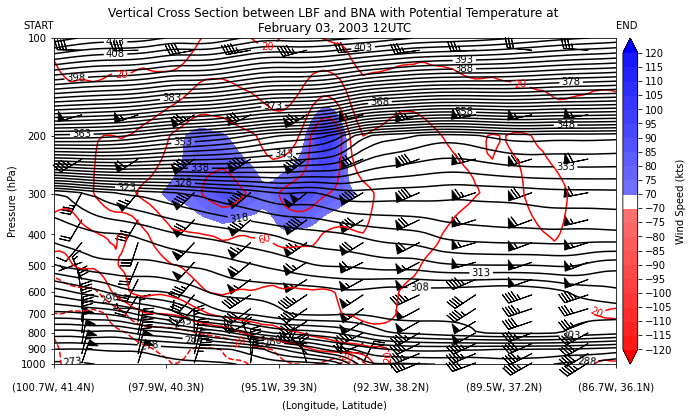

In [28]:
### 3.3a
print('3.3a)')


levels_wsp_normal_shaded = list(np.arange(-120, -69, 5)) + list(np.arange(70, 121, 5))
levels_wsp_normal = np.arange(-120, 121, 20)
levels_theta = np.arange(263, 425, 2.5)
vecSpacing = 7


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

f1 = ax.contourf(range(101), levX, wspd_normal.to('kts'), levels=levels_wsp_normal_shaded, cmap='bwr_r', extend='both', vmin=-130, vmax=130)
cs_wspd = ax.contour(range(101), levX, wspd_normal.to('kts'), levels=levels_wsp_normal, colors='r', linewidths=1.5)
ax.clabel(cs_wspd, cs_wspd.levels[1::2], inline=True, fmt='%1.0f')

th_cont = ax.contour(range(101), levX, theta_alongCrossSection, levels=levels_theta, colors='k', linewidths=1.5)
ax.clabel(th_cont, th_cont.levels[::2], inline=True, fmt='%1.0f')
ax.barbs(range(5, 101, 10), levX[1::vecSpacing], u_alongCrossSection[1::vecSpacing, 5::10].to('kts'), v_alongCrossSection[1::vecSpacing, 5::10].to('kts'), clip_on=False)

cbar = plt.colorbar(f1, ticks=levels_wsp_normal_shaded, label='Wind Speed (kts)', pad=.01)

pairs = ['\n('+'{:.1f}'.format(np.abs(lonX[el].magnitude%-180))+'W, '+'{:.1f}'.format(latX[el].magnitude)+'N)' for el in range(0, 101, 20)]
ax.set_xticks(np.arange(0, 101, 20))

ax.set_xticklabels(pairs)
ax.set_yscale('log')
ax.set_yticks(np.arange(100, 1001, 100))
ax.set_yticklabels(np.arange(100, 1001, 100))
ax.set_xlim(0, 100)
ax.set_ylim(1000, 100)
ax.set_title('Vertical Cross Section between LBF and BNA with Potential Temperature at \n' + dataset_time[timeInd])
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('(Longitude, Latitude)', labelpad=8)
ax.text(0, 95, 'START', ha='right', va='bottom')
ax.text(100, 95, 'END', ha='left', va='bottom')
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_3.3.1.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()

## 4. Cross-Section III, ILN-SSM, 00 UTC on 4 Feb 2003

In [29]:
### 4.1a
print('4.1a)')

sLon, sLat, eLon, eLat = 276.2, 39.4, 275.7, 46.5

desired_time = datetime.strptime('2003-02-04 00UTC', '%Y-%m-%d %HUTC')
desired_time = desired_time.strftime('%B %d, %Y %HUTC')
timeInd = dataset_time.index(desired_time)

z_cross = z[timeInd, :, :, :]
geo_height_cross = z_cross / g

4.1a)


In [30]:
### 4.1b
print('4.1b)')
print('3.1b)')
print('First, we need to set empty arrays to fill in with 3d winds:')
ug_3d = np.zeros((len(level), len(latitude), len(longitude)))
vg_3d = np.zeros((len(level), len(latitude), len(longitude)))
print('The shape of 3d wind arrays:', ug_3d.shape)
print('Does the shape of 3d wind arrays match the shape of temperature, pressure grid:', ug_3d.shape == levelGrid.shape)
print('Confirming they are empty arrays:')
print('   -min, max of ug_3d:', np.min(ug_3d), np.max(ug_3d))
print('   -min, max of vg_3d:', np.min(vg_3d), np.max(vg_3d))

print()
print('Calculate everything we need for geostrophic wind function - that does not depend on height.')
lonGrid, latGrid = np.meshgrid(longitude, latitude) # substitute your subset longitude and latitude
f = mpcalc.coriolis_parameter(np.deg2rad(latGrid)).to('1/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lonGrid, latGrid)

print('Now we write a for-loop in which we loop through one level at a time, and calculate geostrophic winds there.')
for lev in range(len(level)):
    ug, vg = mpcalc.geostrophic_wind(geo_height_cross[lev], f, dx, dy)
    
    ug_3d[lev] = ug
    vg_3d[lev] = vg

ug_3d = ug_3d * ug.units
vg_3d = vg_3d * vg.units

ug_3d.to('kt')
vg_3d.to('kt')
ug_3d.shape

4.1b)
3.1b)
First, we need to set empty arrays to fill in with 3d winds:
The shape of 3d wind arrays: (11, 181, 401)
Does the shape of 3d wind arrays match the shape of temperature, pressure grid: True
Confirming they are empty arrays:
   -min, max of ug_3d: 0.0 0.0
   -min, max of vg_3d: 0.0 0.0

Calculate everything we need for geostrophic wind function - that does not depend on height.
Now we write a for-loop in which we loop through one level at a time, and calculate geostrophic winds there.


(11, 181, 401)

In [31]:
### 4.2a
print('4.2a)')
u_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=ug_3d, startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)
v_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=vg_3d, startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)
theta_alongCrossSection, lonX, latX, levX = calculate_crossSectionField(lons=longitude, lats=latitude, levels=level, field=theta[timeInd, :, :, :], startLon=sLon, startLat=sLat, endLon=eLon, endLat=eLat)

4.2a)


In [32]:
### 4.2b
print('4.2b)')
u_normal, v_normal, wspd_normal, angle = calc_winds_normalToCrossSection(u=u_alongCrossSection, v=v_alongCrossSection, lons=lonX, lats=latX)

4.2b)


4.3a)


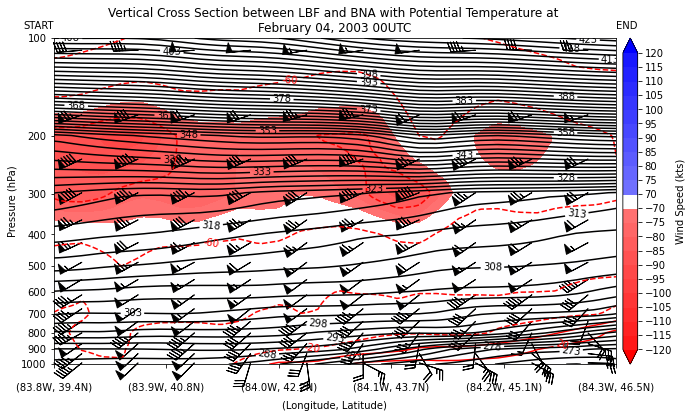

In [33]:
### 4.3a
print('4.3a)')
levels_wsp_normal_shaded = list(np.arange(-120, -69, 5)) + list(np.arange(70, 121, 5))
levels_wsp_normal = np.arange(-120, 121, 20)
levels_theta = np.arange(263, 425, 2.5)
vecSpacing = 7


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

f1 = ax.contourf(range(101), levX, wspd_normal.to('kts'), levels=levels_wsp_normal_shaded, cmap='bwr_r', extend='both', vmin=-130, vmax=130)
cs_wspd = ax.contour(range(101), levX, wspd_normal.to('kts'), levels=levels_wsp_normal, colors='r', linewidths=1.5)
ax.clabel(cs_wspd, cs_wspd.levels[1::2], inline=True, fmt='%1.0f')

th_cont = ax.contour(range(101), levX, theta_alongCrossSection, levels=levels_theta, colors='k', linewidths=1.5)
ax.clabel(th_cont, th_cont.levels[::2], inline=True, fmt='%1.0f')
ax.barbs(range(5, 101, 10), levX[1::vecSpacing], u_alongCrossSection[1::vecSpacing, 5::10].to('kts'), v_alongCrossSection[1::vecSpacing, 5::10].to('kts'), clip_on=False)

cbar = plt.colorbar(f1, ticks=levels_wsp_normal_shaded, label='Wind Speed (kts)', pad=.01)

pairs = ['\n('+'{:.1f}'.format(np.abs(lonX[el].magnitude%-180))+'W, '+'{:.1f}'.format(latX[el].magnitude)+'N)' for el in range(0, 101, 20)]
ax.set_xticks(np.arange(0, 101, 20))

ax.set_xticklabels(pairs)
ax.set_yscale('log')
ax.set_yticks(np.arange(100, 1001, 100))
ax.set_yticklabels(np.arange(100, 1001, 100))
ax.set_xlim(0, 100)
ax.set_ylim(1000, 100)
ax.set_title('Vertical Cross Section between LBF and BNA with Potential Temperature at \n' + dataset_time[timeInd])
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('(Longitude, Latitude)', labelpad=8)
ax.text(0, 95, 'START', ha='right', va='bottom')
ax.text(100, 95, 'END', ha='left', va='bottom')
plt.savefig('ATMS370_W2022_Lab15_Fig_FIGURE_4.3.1.png', dpi=200, bbox_inches='tight', facecolor='w', transparent=False)

plt.show()